## **TAREA VISUALIZACIÓN**

**Adrián Asenjo Pérez**

Cargar librerías

In [457]:
import pandas as pd
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import plotnine
from plotnine import *

import plotly.express as px

print('Librerías cardas')

Librerías cardas


Lectura de ficheros

- https://www.ine.es/jaxiT3/Tabla.htm?t=26014
- https://www.ine.es/jaxiT3/Tabla.htm?t=9691

In [458]:
df_delincuencia =pd.read_csv('./delilncuencia.csv', sep=';')
df_poblacion = pd.read_csv('./poblacion_.csv', sep=';')

Identificación de que ambos DF (delincuencia) contenga la misma información geográfica que el DF de población.

In [459]:
# Identificación de los países (nacionalidades) de las que tenemos incidencia de crímenes que estén incluidas en el fichero de población.


paises_df_delincuencia = list(set(df_delincuencia['Nacionalidad']))
paises_df_poblacion = list(set(df_poblacion['Nacionalidad']))

pendiente = []

for i in paises_df_delincuencia:
    
    if i not in paises_df_poblacion:
        
        pendiente.append(i)


print(f'El total de páises no identificados en el df de población son {len(pendiente)} y son las siguientes {str(pendiente)}.')



El total de páises no identificados en el df de población son 1 y son las siguientes ['De América'].


Ajuste del DF Poblacion

- Ajustar los periodos y los sexos.
- Agrupación geografías américas en una sola

In [460]:
# Paso uno filtrar por ambos sexos 

df_poblacion = df_poblacion[df_poblacion['Sexo']=='Ambos sexos']


# Paso dos filtrar por Total Nacional en el campo Provincias

df_poblacion = df_poblacion[df_poblacion['Provincias']=='Total Nacional']

# Paso tres desagregar por año y mes

df_poblacion['año'] = df_poblacion['Periodo'].map(lambda x: str(x).split(' ')[-1])

df_poblacion['mes'] = df_poblacion['Periodo'].map(lambda x: str(x).split(' ')[-3])

# Paso 4, nos quedamos sólo con la medición de enero

df_poblacion = df_poblacion[df_poblacion['mes']=='enero']

# Paso 5, pasar el totoal a float

df_poblacion['Total'] = df_poblacion['Total'].map(lambda x:  float(str(x).replace('.','').replace(',','.')))

# Paso 6 creación pivot table

poblacion_pivot = pd.pivot_table(df_poblacion[['año', 'Nacionalidad', 'Total']].drop_duplicates(), index=['año', 'Nacionalidad'], aggfunc=np.sum)
poblacion_pivot = poblacion_pivot.reset_index()

In [461]:
# Agrupacion de las nacionalidas de américa en una 

american_ones = ['De América del Norte', 'De Centro América y Caribe', 'De Sudamérica']

años = list(set(poblacion_pivot['año']))

nuevos_df = []

for años_ in años:
    
    p1 = poblacion_pivot[(poblacion_pivot['año']==años_)&(poblacion_pivot['Nacionalidad']==american_ones[0])]
    p2 = poblacion_pivot[(poblacion_pivot['año']==años_)&(poblacion_pivot['Nacionalidad']==american_ones[1])]
    p3 = poblacion_pivot[(poblacion_pivot['año']==años_)&(poblacion_pivot['Nacionalidad']==american_ones[2])] 

    v1 = list(p1['Total'])[0]
    v2 = list(p2['Total'])[0]
    v3 = list(p3['Total'])[0]
   
    resultado = v1 + v2 + v3
    

    linea = [años_,'De América', resultado]
    
    nuevos_df.append(tuple(linea))

# Creación nuevo DF

df_america = pd.DataFrame(nuevos_df, columns=list(poblacion_pivot.columns))

# Unificación con todo el DF

poblacion_pivot_ = pd.concat([poblacion_pivot, df_america])

# Ordenación 

poblacion_pivot_ = poblacion_pivot_.sort_values(by=['año', 'Nacionalidad'])

Unión de ambos DF

- Se va a crear una cláve única (año + nacionalidad) en ambos DF para poderlos unir. 
- Union de ambos df (siendo el cruce con el de delincuencia)

In [462]:
### Crear la variable cruce, como unión entre la nacionalidad y el periodo ###

### DF Delincuencia

df_delincuencia['Periodo_'] = df_delincuencia['Periodo'].map(lambda x: str(x)) # Se crea una variable con el periodo en versión str

df_delincuencia['_cruce_'] = df_delincuencia['Nacionalidad'] + '_' + df_delincuencia['Periodo_'] # creación clave única

df_delincuencia.drop(['Periodo_'], axis=1, inplace= True) # Eliminación de la variable creada

df_delincuencia.rename(columns={'Total':'Total_Delincuencia'}, inplace=True) # Renombrar

In [463]:
### DF pobalacion

poblacion_pivot_['año_'] = poblacion_pivot_['año'].map(lambda x: str(x)) # Pasar la variable año a str


poblacion_pivot_['_cruce_'] = poblacion_pivot_['Nacionalidad'] + '_' + poblacion_pivot_['año_'] # creación clave única

poblacion_pivot_.drop(['año_'], axis=1, inplace= True) # Eliminación de la variable creada

poblacion_pivot_.rename(columns={'Total':'Total_Poblacion'}, inplace=True) # Renombrar


In [464]:
# Cruce

df_poblacion_vs_delincuencia = pd.merge(left=df_delincuencia, right= poblacion_pivot_[['_cruce_', 'Total_Poblacion']].drop_duplicates(), on='_cruce_', how='inner') # Unión
df_poblacion_vs_delincuencia.drop(['_cruce_'], axis=1, inplace= True) # Eliminación regla de cruce

df_poblacion_vs_delincuencia['%_Delincuencia_vs_poblacion'] = (df_poblacion_vs_delincuencia['Total_Delincuencia'] / df_poblacion_vs_delincuencia['Total_Poblacion'])*100 # Porcentaje de delincuncia en función de la población

df_poblacion_vs_delincuencia['Tipo de Delito: Nivel 2'] = df_poblacion_vs_delincuencia['Tipo de Delito: Nivel 2'].fillna('Unknown') # Delitos sin etiquetar como desconcocidos.

df_poblacion_vs_delincuencia['%_Delincuencia_vs_poblacion'] = df_poblacion_vs_delincuencia['%_Delincuencia_vs_poblacion'].fillna(0.000000)






# **Gráficos**



**Gráfico evolución delincuencia vs nacionalidad**

- Tabla Dinámica

In [465]:
# Cración de tabla dinámica con los datos necesarios.

salida = pd.pivot_table(df_poblacion_vs_delincuencia[['%_Delincuencia_vs_poblacion', 'Periodo', 'Nacionalidad']], index='Periodo', columns='Nacionalidad', aggfunc='sum')

salida = salida[list(salida.columns)[0:6]].fillna(0.000)
salida

%_Delincuencia_vs_poblacion                                  \
Nacionalidad                   De Africa De América   De Asia De Oceanía   
Periodo                                                                    
2013                            0.345800   0.374715  0.636993  19.053310   
2014                            0.387069   0.410335  0.681979   1.276962   
2015                            0.455635   0.500998  0.687481   1.059402   
2016                            0.579322   0.599514  0.869136   2.123374   
2017                            0.532919   0.607344  0.767418   1.267196   
2018                            0.516910   0.517165  0.769214   0.879984   
2019                            0.436501   0.480509  0.771119   1.285493   
2020                            0.566456   0.409083  0.583603   0.490828   
2021                            0.498964   0.384094  0.608873   0.394763   

                                                       
Nacionalidad  Española País de Europa menos UE27_2020  
Periodo                                                
2013          0.007741                       0.000000  
2014          0.007018                       0.000000  
2015          0.007237                       0.000000  
2016          0.005916                       0.000000  
2017          0.005852                       0.000000  
2018          0.007740                       0.000000  
2019          0.007781                       0.000000  
2020          0.006230                       0.000000  
2021          0.007252                       0.540262

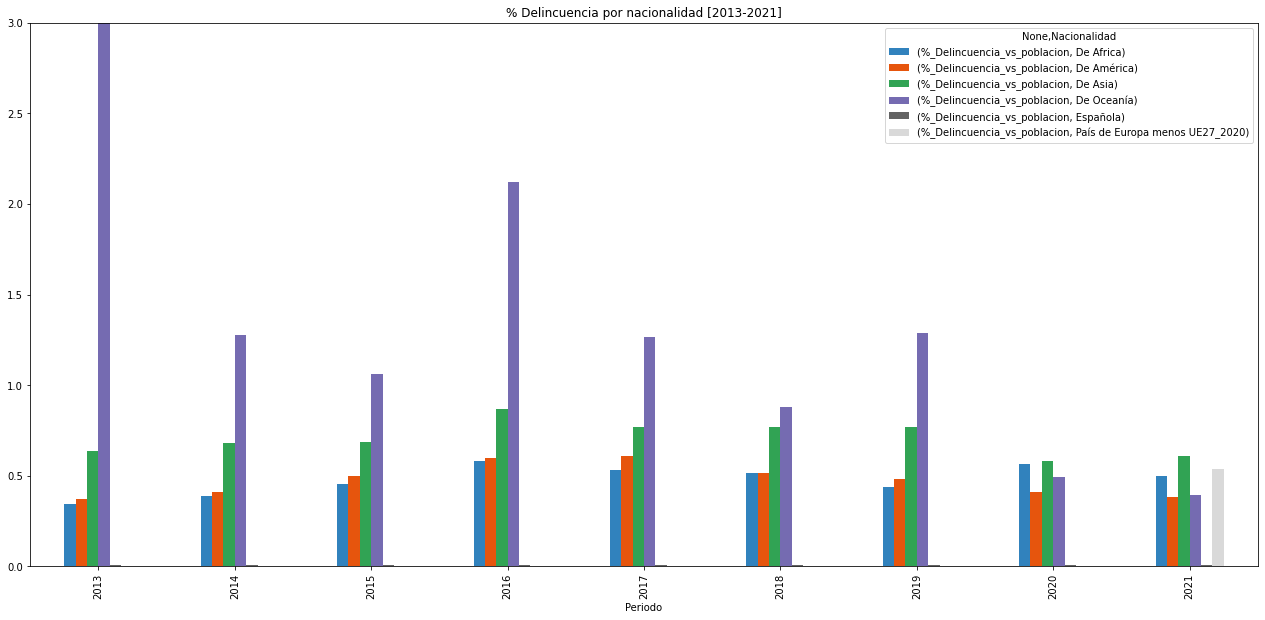

In [466]:
salida.plot(kind='bar', figsize=(22, 10), ylim=[0, 3], title='% Delincuencia por nacionalidad [2013-2021]', colormap='tab20c');

**Gráfico evolución de delitos por tipo de delito.**

In [467]:
# Creación de Diccionario

dic_datos = {}

for i in list(set(df_poblacion_vs_delincuencia['Tipo de Delito: Nivel 2'])):
    
    df_poblacion_vs_delincuencia_ = df_poblacion_vs_delincuencia[(df_poblacion_vs_delincuencia['Nacionalidad']!='Total')&(df_poblacion_vs_delincuencia['Tipo de Delito: Nivel 2']==i)]
    
    df_poblacion_vs_delincuencia_ = df_poblacion_vs_delincuencia_[df_poblacion_vs_delincuencia['%_Delincuencia_vs_poblacion']>0]
    
    dic_datos[i] = df_poblacion_vs_delincuencia_
          

C:\Users\asenj\AppData\Local\Temp/ipykernel_8976/3687229707.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [468]:
# Posiblidad de delitos 

print(dic_datos.keys(), '\n', len(list(dic_datos.keys())))

dict_keys(['6 Contra la libertad', '8 Contra la libertad e indemnidad sexuales', 'Unknown', '12 Contra las relaciones familiares', '18 Falsedades', '20 Contra la Administración de Justicia', '7 Torturas e integridad moral', '3 Lesiones', '19 Contra la Administración Pública', '13 Contra el patrimonio y el orden socioeconómico', '22 Contra el orden público', 'R Resto de delitos', '17 Contra la seguridad colectiva', '1 Homicidio y sus formas']) 
 14


C:\Users\asenj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\plotnine\layer.py:411: PlotnineWarning:

geom_col : Removed 117 rows containing missing values.



6 Contra la libertad


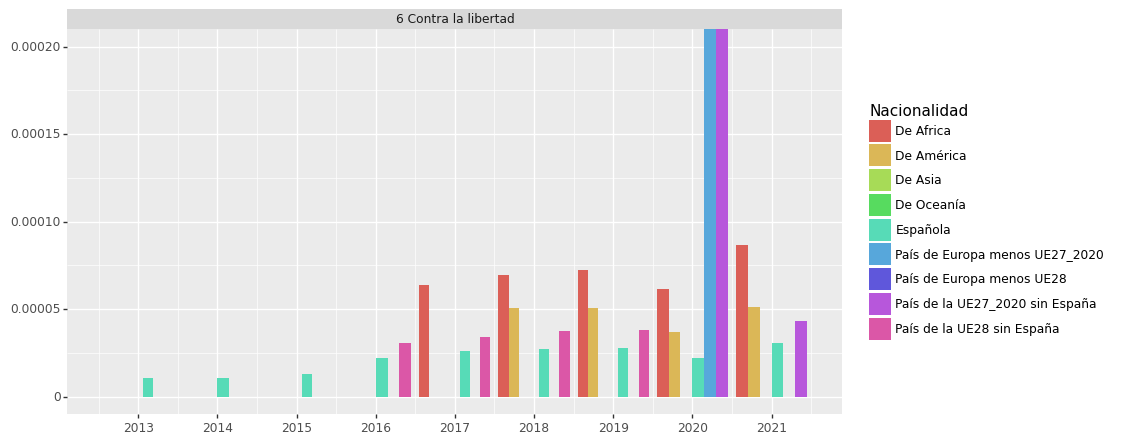

<ggplot: (153333822724)>

In [469]:
salix = list(dic_datos.keys())[0]

print(salix)

(
    ggplot(dic_datos[salix])  # What data to use
    + aes(x = "Periodo", 
          y = "%_Delincuencia_vs_poblacion",
          fill = 'Nacionalidad',
          )  # What variable to use
     + scale_y_continuous(limits=(0, 0.0002))
     + scale_x_continuous(breaks=range(2012,2022,1))
    #+ geom_smooth(method = "lowess", span = 0.005)  # Geometric object to use for drawing
    + geom_col(position = "dodge")
     + facet_grid(facets = ". ~ Tipo de Delito: Nivel 2")
     + labs( y='', x='')
    
     + theme(figure_size=(10, 5))
   
     
)

18 Falsedades


C:\Users\asenj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\plotnine\layer.py:411: PlotnineWarning:

geom_col : Removed 285 rows containing missing values.



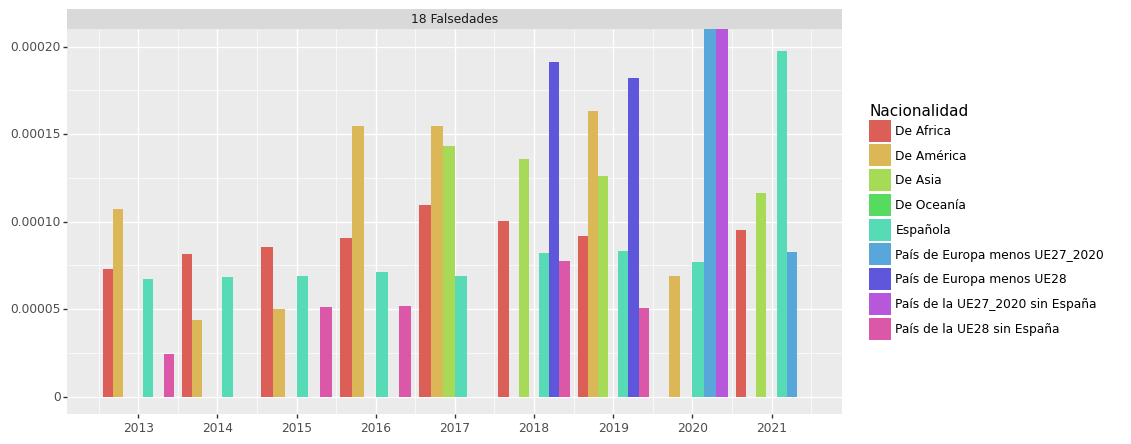

<ggplot: (153337761961)>

In [470]:
salix = list(dic_datos.keys())[4]

print(salix)

(
    ggplot(dic_datos[salix])  # What data to use
    + aes(x = "Periodo", 
          y = "%_Delincuencia_vs_poblacion",
          fill = 'Nacionalidad',
          )  # What variable to use
     + scale_y_continuous(limits=(0, 0.0002))
     + scale_x_continuous(breaks=range(2012,2022,1))
    #+ geom_smooth(method = "lowess", span = 0.005)  # Geometric object to use for drawing
    + geom_col(position = "dodge")
     + facet_grid(facets = ". ~ Tipo de Delito: Nivel 2")
     + labs( y='', x='')
    
     + theme(figure_size=(10, 5))
   
     
)

20 Contra la Administración de Justicia


C:\Users\asenj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\plotnine\layer.py:411: PlotnineWarning:

geom_col : Removed 248 rows containing missing values.



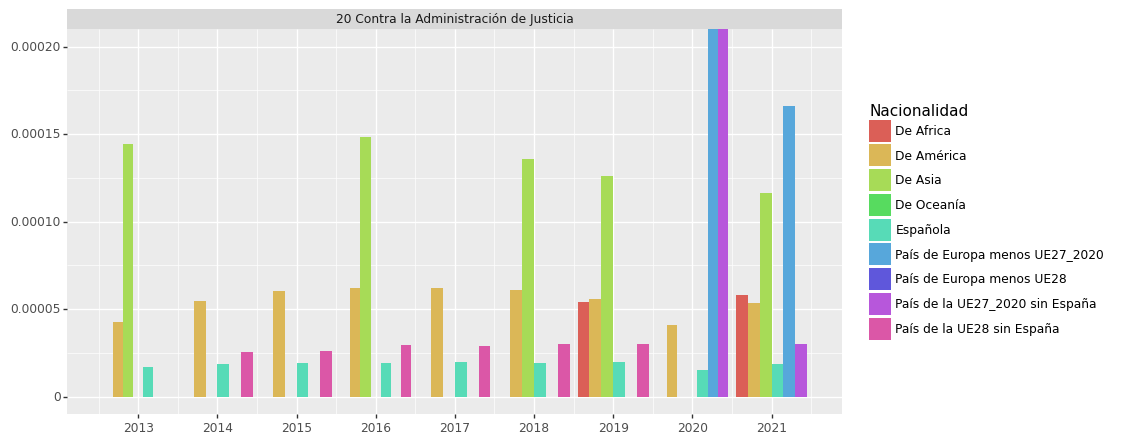

<ggplot: (153340307845)>

In [471]:
salix = list(dic_datos.keys())[5]

print(salix)

(
    ggplot(dic_datos[salix])  # What data to use
    + aes(x = "Periodo", 
          y = "%_Delincuencia_vs_poblacion",
          fill = 'Nacionalidad',
          )  # What variable to use
     + scale_y_continuous(limits=(0, 0.0002))
     + scale_x_continuous(breaks=range(2012,2022,1))
    #+ geom_smooth(method = "lowess", span = 0.005)  # Geometric object to use for drawing
    + geom_col(position = "dodge")
     + facet_grid(facets = ". ~ Tipo de Delito: Nivel 2")
     + labs( y='', x='')
    
     + theme(figure_size=(10, 5))
   
     
)

7 Torturas e integridad moral


C:\Users\asenj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\plotnine\layer.py:411: PlotnineWarning:

geom_col : Removed 93 rows containing missing values.



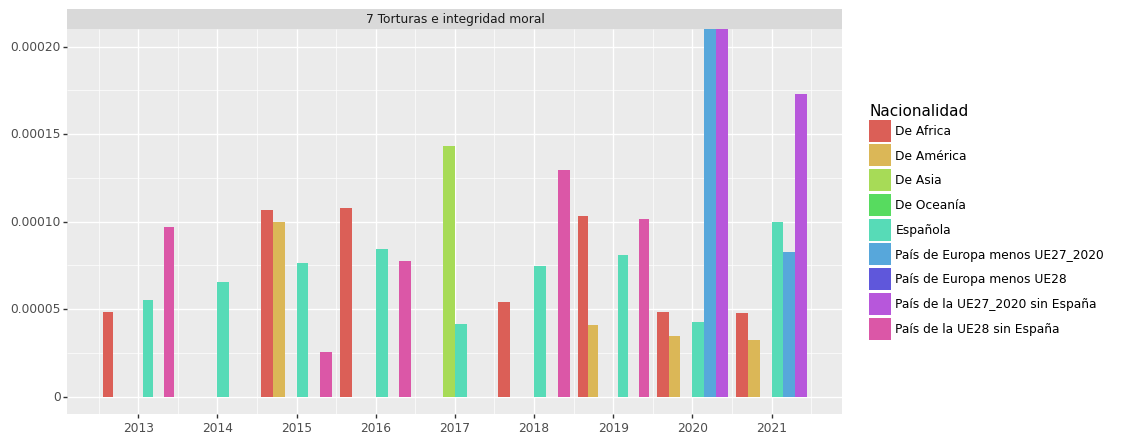

<ggplot: (153341068752)>

In [472]:
salix = list(dic_datos.keys())[6]

print(salix)

(
    ggplot(dic_datos[salix])  # What data to use
    + aes(x = "Periodo", 
          y = "%_Delincuencia_vs_poblacion",
          fill = 'Nacionalidad',
          )  # What variable to use
     + scale_y_continuous(limits=(0, 0.0002))
     + scale_x_continuous(breaks=range(2012,2022,1))
    #+ geom_smooth(method = "lowess", span = 0.005)  # Geometric object to use for drawing
    + geom_col(position = "dodge")
     + facet_grid(facets = ". ~ Tipo de Delito: Nivel 2")
     + labs( y='', x='')
    
     + theme(figure_size=(10, 5))
   
     
)

3 Lesiones


C:\Users\asenj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\plotnine\layer.py:411: PlotnineWarning:

geom_col : Removed 36 rows containing missing values.



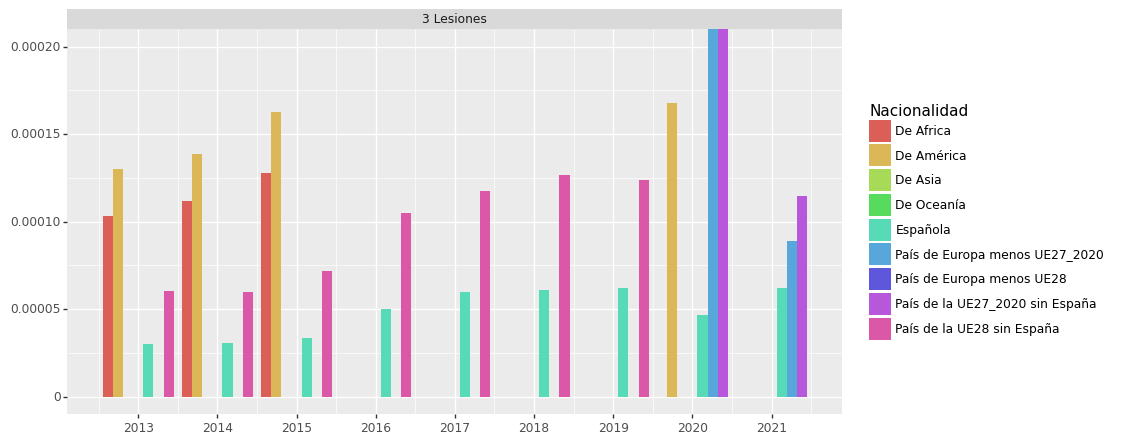

<ggplot: (153341399540)>

In [473]:
salix = list(dic_datos.keys())[7]

print(salix)

(
    ggplot(dic_datos[salix])  # What data to use
    + aes(x = "Periodo", 
          y = "%_Delincuencia_vs_poblacion",
          fill = 'Nacionalidad',
          )  # What variable to use
     + scale_y_continuous(limits=(0, 0.0002))
     + scale_x_continuous(breaks=range(2012,2022,1))
    #+ geom_smooth(method = "lowess", span = 0.005)  # Geometric object to use for drawing
    + geom_col(position = "dodge")
     + facet_grid(facets = ". ~ Tipo de Delito: Nivel 2")
     + labs( y='', x='')
    
     + theme(figure_size=(10, 5))
   
     
)

19 Contra la Administración Pública


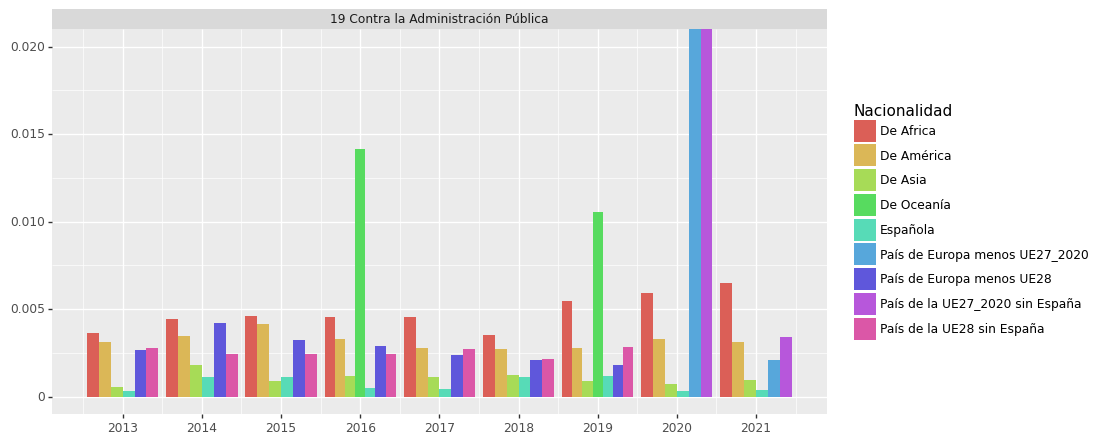

<ggplot: (153341470452)>

In [474]:
salix = list(dic_datos.keys())[8]

print(salix)

(
    ggplot(dic_datos[salix])  # What data to use
    + aes(x = "Periodo", 
          y = "%_Delincuencia_vs_poblacion",
          fill = 'Nacionalidad',
          )  # What variable to use
     + scale_y_continuous(limits=(0, 0.02))
     + scale_x_continuous(breaks=range(2012,2022,1))
    #+ geom_smooth(method = "lowess", span = 0.05)  # Geometric object to use for drawing
    + geom_col(position = "dodge")
     + facet_grid(facets = ". ~ Tipo de Delito: Nivel 2")
     + labs( y='', x='')
    
     + theme(figure_size=(10, 5))
   
     
)

13 Contra el patrimonio y el orden socioeconómico


C:\Users\asenj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\plotnine\layer.py:411: PlotnineWarning:

geom_col : Removed 143 rows containing missing values.



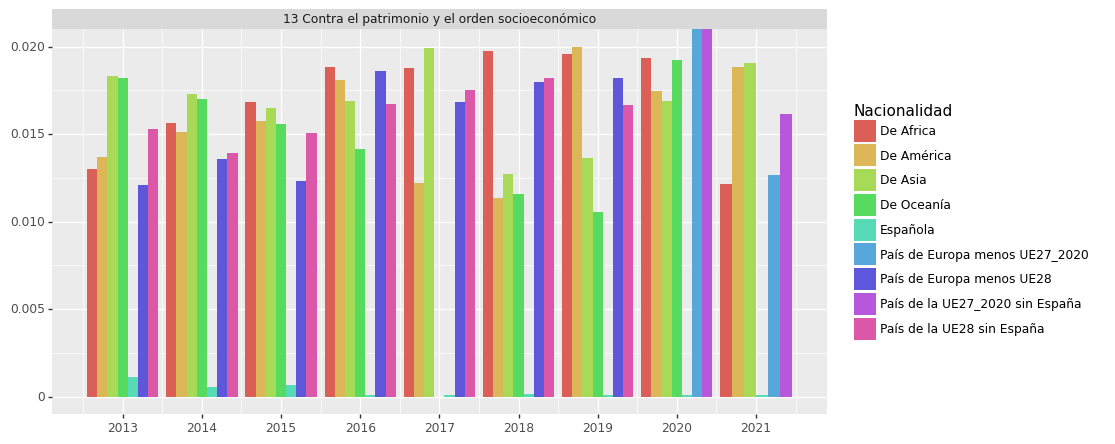

<ggplot: (153341470058)>

In [475]:
salix = list(dic_datos.keys())[9]

print(salix)

(
    ggplot(dic_datos[salix])  # What data to use
    + aes(x = "Periodo", 
          y = "%_Delincuencia_vs_poblacion",
          fill = 'Nacionalidad',
          )  # What variable to use
     + scale_y_continuous(limits=(0, 0.02))
     + scale_x_continuous(breaks=range(2012,2022,1))
    #+ geom_smooth(method = "lowess", span = 0.05)  # Geometric object to use for drawing
    + geom_col(position = "dodge")
     + facet_grid(facets = ". ~ Tipo de Delito: Nivel 2")
     + labs( y='', x='')
    
     + theme(figure_size=(10, 5))
   
     
)

22 Contra el orden público


C:\Users\asenj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\plotnine\layer.py:411: PlotnineWarning:

geom_col : Removed 72 rows containing missing values.



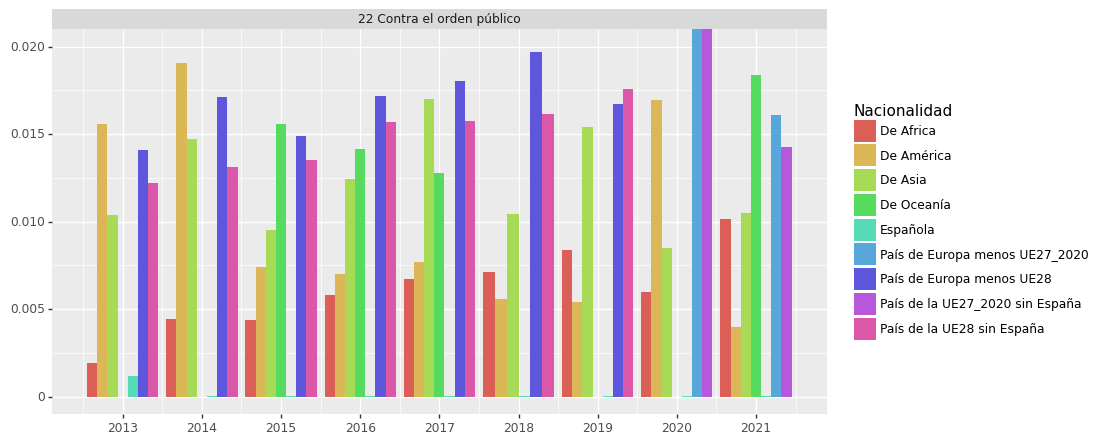

<ggplot: (153341701626)>

In [476]:
salix = list(dic_datos.keys())[10]

print(salix)

(
    ggplot(dic_datos[salix])  # What data to use
    + aes(x = "Periodo", 
          y = "%_Delincuencia_vs_poblacion",
          fill = 'Nacionalidad',
          )  # What variable to use
     + scale_y_continuous(limits=(0, 0.02))
     + scale_x_continuous(breaks=range(2012,2022,1))
    #+ geom_smooth(method = "lowess", span = 0.05)  # Geometric object to use for drawing
    + geom_col(position = "dodge")
     + facet_grid(facets = ". ~ Tipo de Delito: Nivel 2")
     + labs( y='', x='')
    
     + theme(figure_size=(10, 5))
   
     
)

R Resto de delitos


C:\Users\asenj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\plotnine\layer.py:411: PlotnineWarning:

geom_col : Removed 3 rows containing missing values.



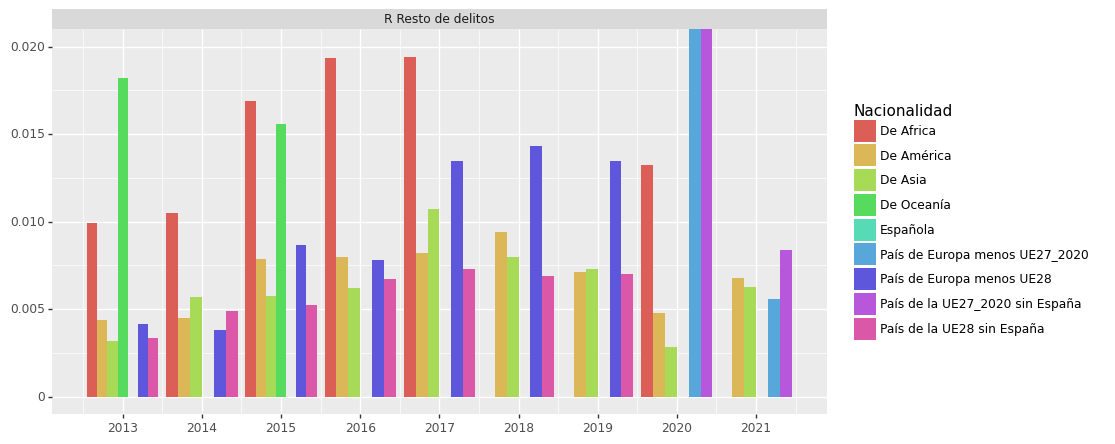

<ggplot: (153344026618)>

In [477]:
salix = list(dic_datos.keys())[11]

print(salix)

(
    ggplot(dic_datos[salix])  # What data to use
    + aes(x = "Periodo", 
          y = "%_Delincuencia_vs_poblacion",
          fill = 'Nacionalidad',
          )  # What variable to use
     + scale_y_continuous(limits=(0, 0.02))
     + scale_x_continuous(breaks=range(2012,2022,1))
    #+ geom_smooth(method = "lowess", span = 0.05)  # Geometric object to use for drawing
    + geom_col(position = "dodge")
     + facet_grid(facets = ". ~ Tipo de Delito: Nivel 2")
     + labs( y='', x='')
    
     + theme(figure_size=(10, 5))
   
     
)

17 Contra la seguridad colectiva


C:\Users\asenj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\plotnine\layer.py:411: PlotnineWarning:

geom_col : Removed 66 rows containing missing values.



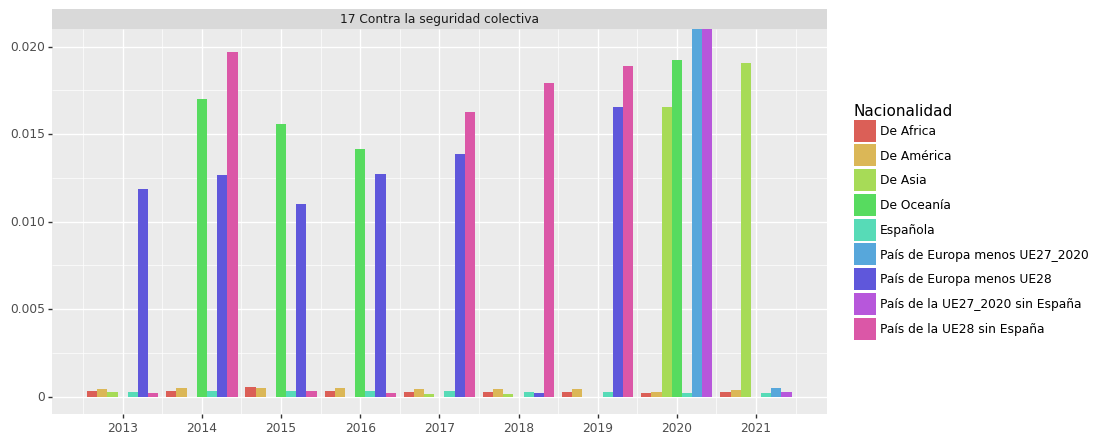

<ggplot: (153344101867)>

In [478]:
salix = list(dic_datos.keys())[12]

print(salix)

(
    ggplot(dic_datos[salix])  # What data to use
    + aes(x = "Periodo", 
          y = "%_Delincuencia_vs_poblacion",
          fill = 'Nacionalidad',
          )  # What variable to use
     + scale_y_continuous(limits=(0, 0.02))
     + scale_x_continuous(breaks=range(2012,2022,1))
    #+ geom_smooth(method = "lowess", span = 0.05)  # Geometric object to use for drawing
    + geom_col(position = "dodge")
     + facet_grid(facets = ". ~ Tipo de Delito: Nivel 2")
     + labs( y='', x='')
    
     + theme(figure_size=(10, 5))
   
     
)

In [479]:
px.scatter(df_poblacion_vs_delincuencia_, 
           y="%_Delincuencia_vs_poblacion", 
           x="Nacionalidad", 
           color="Tipo de Delito: Nivel 2",
           #size='%_Delincuencia_vs_poblacion',
           animation_frame="Periodo",
           animation_group="Tipo de Delito: Nivel 1",
           title='Secondary enrollment vs Life expectancy [2000 - 2015]',
           range_y=[0, 0.2])